%% Packages

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from numpy import arange, exp, sqrt, log, mean, std, nonzero, isnan, array, zeros, ones, amax, amin, maximum, minimum
from numpy import concatenate, arange, interp, diff, cov, var, diag, eye, cumsum, tile, transpose, nan, hstack, vstack
from numpy import setdiff1d
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.optimize import fmin
from scipy.stats import norm
from numpy.random import normal
from NLLS_Func import NLLS, NLLS_Min
from HoLee_SimpleBDT_Tree import fmin_HoLee_SimpleBDT_Tree,HoLee_SimpleBDT_Tree

In [3]:
print('==================================================================')
print('INTEREST RATE TREES  & VALUATION')
print('==================================================================')

INTEREST RATE TREES  & VALUATION


% load data

In [4]:
Data     = array(pd.read_excel('HW6_Data_Bonds.xlsx',sheet_name='Sheet1',skiprows=4,usecols=arange(9)))
Mat      = array(pd.read_excel('HW6_Data_Bonds.xlsx',sheet_name='Sheet1',skiprows=4,usecols=arange(10,70)))    # Maturity Matrix (N x T) where N=number of bonds, T=max number of maturities.
CashFlow = array(pd.read_excel('HW6_Data_Bonds.xlsx',sheet_name='Sheet1',skiprows=4,usecols=arange(72,132)))   # % This is the cash flow matrix (N x T). Cash flow of each bond corresponding to each maturity.

assign names to some of the data

In [5]:
Bid        = Data[:,5]
Ask        = Data[:,6]
CleanPrice = (Bid+Ask)/2
Price      = CleanPrice + Data[:,8]     # add accrued interest to the clean prices.

% Use Nelson Siegel Model.

In [6]:
vec0 = array([5.3664,-0.1329,-1.2687,132.0669])/100    # use solution as starting value.

In [7]:
vec  = fmin(func=NLLS_Min,x0=vec0,args=(Price,Mat,CashFlow))  # minimization algorithm. The 'NLLS' calls the matlab file with the minimization.
                                                              # vec0 is starting value; Price, Mat, CashFlow are passed to ENLLS.m to compute the minimizing function.
# translate solution back in "formulas"
th0 = vec[0]; th1 = vec[1]; th2 = vec[2]; la = vec[3]

Optimization terminated successfully.
         Current function value: 7.826728
         Iterations: 58
         Function evaluations: 105


In [8]:
J, PPhat = NLLS(vec, Price, Mat, CashFlow)

Text(0, 0.5, 'Price')

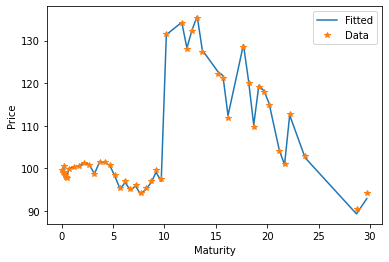

In [9]:
plt.figure(1)
plt.plot(Data[:,7],PPhat,Data[:,7],Price,'*')
plt.legend(('Fitted','Data'))
plt.xlabel('Maturity')
plt.ylabel('Price')

In [10]:
hs  = 1/2
T   = arange(hs,30+hs,hs)
Ycc = th0+(th1+th2)*(1-exp(-T/la))/(T/la)-th2*exp(-T/la)

Discount

In [11]:
ZZcc=exp(-Ycc*T)

In [12]:
ZZcc

array([0.97497633, 0.95143434, 0.92863217, 0.90622323, 0.88407369,
       0.86215811, 0.84050078, 0.81914399, 0.79813186, 0.77750291,
       0.75728742, 0.73750715, 0.71817621, 0.69930237, 0.68088836,
       0.66293301, 0.64543228, 0.62838005, 0.61176871, 0.59558966,
       0.57983366, 0.56449108, 0.54955208, 0.53500675, 0.52084524,
       0.50705776, 0.49363468, 0.48056655, 0.4678441 , 0.45545828,
       0.44340023, 0.43166132, 0.42023313, 0.40910746, 0.39827631,
       0.38773189, 0.37746663, 0.36747313, 0.35774421, 0.34827285,
       0.33905225, 0.33007576, 0.32133693, 0.31282946, 0.30454722,
       0.29648426, 0.28863477, 0.28099309, 0.27355373, 0.26631133,
       0.25926067, 0.25239668, 0.24571442, 0.23920907, 0.23287595,
       0.2267105 , 0.22070829, 0.21486498, 0.20917638, 0.20363838])

Fwd rates

In [13]:
FWD = -log(ZZcc[1:]/ZZcc[0:-1])/hs
FWD = hstack((Ycc[0],FWD))

Text(0, 0.5, 'Z')

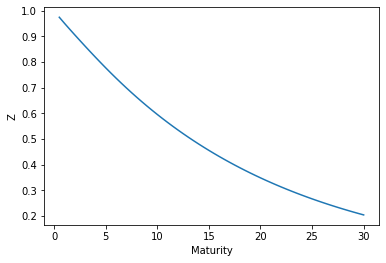

In [14]:
plt.figure(2)
plt.plot(T,ZZcc)
plt.xlabel('Maturity')
plt.ylabel('Z')

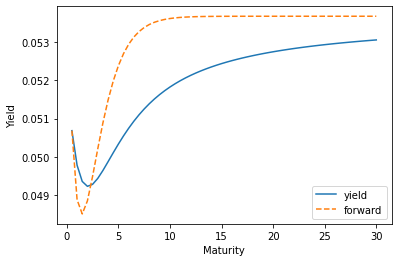

In [15]:
plt.figure(3)
plt.plot(T,Ycc,T,FWD,'--')
plt.xlabel('Maturity')
plt.ylabel('Yield')
plt.legend(('yield','forward','location','northwest'))

% BUILDING A RECOMBINING BINOMIAL TREE

load time series of six month rates

In [16]:
data = array(pd.read_csv('HW6_FRB_H15.csv',skiprows=5,usecols=[1]))[:,0]
n = data.shape[0]
DataY6 = data/100  # back in decimals
P6     = (1-180/360*DataY6)
rr6    =  -1/0.5*log(P6)

In [19]:
r0 = Ycc[0]

Build tree, semi-annual increments

In [20]:
BDT_Flag=0 # = 0: HoLee; =0
if BDT_Flag==0:
    #sigma = 0.016
    sigma = np.std(np.diff(rr6),ddof=1) * np.sqrt(12)   # note: units (month) must be annualized
else:
    #r_t_mean = np.mean(rr6)
    #sigma_r = np.std(np.diff(rr6),ddof=1)
    #sigma_z = sigma_r / r_t_mean
    #sigma = sigma_z * np.sqrt(12)    # note: units (month) must be annualized
    zz6 = np.log(rr6)
    sigma = np.std(np.diff(zz6),ddof=1) * np.sqrt(12) 

In [22]:
ImTree = zeros((int(30/hs),int(30/hs)))
ZZTree = zeros((int(30/hs+1),int(30/hs+1),int(30/hs)))

In [23]:
ImTree[0,0]     = r0              # root of the tree
ZZTree[0,0,0]   = exp(-r0*hs)     # first zero coupon bond (maturity i=2)
ZZTree[0:1,1,0] = 1

In [24]:
ImTree_1 = ImTree

In [25]:
FFF   = zeros(int(30/hs)-1)
theta = zeros(int(30/hs)-1)
for i in arange(1,int(30/hs)):
    theta_i    = fmin(func=fmin_HoLee_SimpleBDT_Tree,x0=0,args=(ZZcc[i],ImTree_1,i,sigma,hs,BDT_Flag))
    theta[i-1] = theta_i
    FF,ImTree,ZZTreei = HoLee_SimpleBDT_Tree(theta_i,ZZcc[i],ImTree_1,i,sigma,hs,BDT_Flag)
    FFF[i-1] = FF
    ImTree_1 = ImTree
    ZZTree[0:i+2,0:i+2,i] = ZZTreei

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 14
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 14
Optimization terminated successfully.
   

In [26]:
yyTree = -log(ZZTree[0,0,:])/T

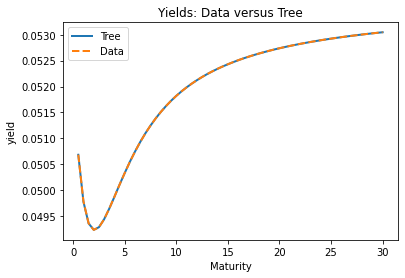

In [27]:
plt.figure(4)
plt.plot(T,yyTree,T,Ycc,'--',linewidth=2)
plt.title('Yields: Data versus Tree')
plt.xlabel('Maturity')
plt.ylabel('yield')
plt.legend(('Tree','Data'),loc='best')

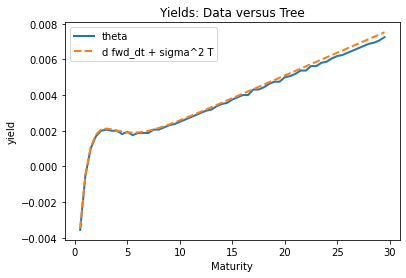

In [28]:
if BDT_Flag==0: # this only works if we are in the original HoLee model
    plt.figure(5)
    plt.plot(T[:-1],theta,T[:-1],(FWD[1:]-FWD[:-1])/hs+sigma**2*T[:-1],'--',linewidth=2)
    plt.title('Yields: Data versus Tree')
    plt.xlabel('Maturity')
    plt.ylabel('yield')
    plt.legend(('theta','d fwd_dt + sigma^2 T'),loc='best')

% Price of the Freddie Mac callable bond on the tree

In [30]:
coupon = 3
TBond  = 20
FCT    = 4                    # first call time
iT     = int(TBond/hs+1)      # step at maturity: always 1 more step than T/hs for maturity
iFCT   = int(FCT/hs+1)        # step at first call time

In [31]:
pi     = 0.5             # Risk Neutral Probability of up movement

In [32]:
PPTree_NC = zeros((iT,iT))    # initialize the matrix for the non-callable coupon bond with maturity i.
Call      = zeros((iT,iT))    # initialize the matrix for American call coupon bond with maturity i.

final payoff of non-callable bond

In [33]:
PPTree_NC[0:iT,iT-1] = 100 + coupon 
Call[0:iT, iT-1] = 0 # final price is equal to 100

backward algorithm

In [34]:
for j in range(iT-1, 0, -1):
    # Discount factor using rates at time j-1 
    discount = np.exp(-ImTree[0:j, j-1] * hs)
    
    # Expected value from up and down moves
    cont_NC = pi * PPTree_NC[0:j, j] + (1 - pi) * PPTree_NC[1:j+1, j]
    cont_Call = pi * Call[0:j, j] + (1 - pi) * Call[1:j+1, j]
    
    # Discount and add coupon
    PPTree_NC[0:j, j-1] = cont_NC * discount + coupon
    call_val = cont_Call * discount 

    # Apply call logic only after First Call Date
    if j >= iFCT:
        # Issuer can redeem at par (100), so call value is the gain from calling
        Call[0:j, j-1] = np.maximum(PPTree_NC[0:j, j-1] - 100 - coupon, call_val)
    else:
        # Before call date, option has no value beyond continuation
        Call[0:j, j-1] = call_val
        
PPTree_NC[0,0] = PPTree_NC[0,0] - coupon

In [37]:
print('Price Freddie Mac Callable Bond')
print('P_NC, Call, P_Call')
print(np.round(array([PPTree_NC[0,0],Call[0,0],PPTree_NC[0,0]-Call[0,0]]),4))

Price Freddie Mac Callable Bond
P_NC, Call, P_Call
[108.5545  17.0245  91.53  ]


In [38]:
import numpy as np

# Set print options to 2 decimal places
np.set_printoptions(precision=2, suppress=True)

print("📘 First 10x10 of Non-Callable Bond Tree:")
print(PPTree_NC[:10, :10])

print("\n🔔 First 10x10 of Call Option Tree:")
print(Call[:10, :10])

print("\n💰 First 10x10 of Callable Bond Tree:")
PPTree_C = PPTree_NC - Call
print(PPTree_C[:10, :10])

📘 First 10x10 of Non-Callable Bond Tree:
[[108.55  96.8   84.88  75.19  67.25  60.68  55.2   50.59  46.67  43.31]
 [  0.   125.88 108.45  94.51  83.26  74.08  66.53  60.26  55.01  50.56]
 [  0.     0.   141.97 121.59 105.38  92.36  81.79  73.13  65.96  59.98]
 [  0.     0.     0.   159.99 136.33 117.59 102.58  90.45  80.53  72.35]
 [  0.     0.     0.     0.   180.06 152.76 131.19 113.97 100.08  88.76]
 [  0.     0.     0.     0.     0.   202.23 170.9  146.21 126.54 110.71]
 [  0.     0.     0.     0.     0.     0.   226.46 190.75 162.64 140.28]
 [  0.     0.     0.     0.     0.     0.     0.   252.68 212.21 180.41]
 [  0.     0.     0.     0.     0.     0.     0.     0.   280.7  235.16]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.   310.25]]

🔔 First 10x10 of Call Option Tree:
[[ 17.02  10.08   5.63   2.97   1.5    0.72   0.33   0.14   0.06   0.02]
 [  0.    24.85  15.14   8.69   4.69   2.42   1.19   0.56   0.25   0.1 ]
 [  0.     0.    35.49  22.34  13.22   7.32   

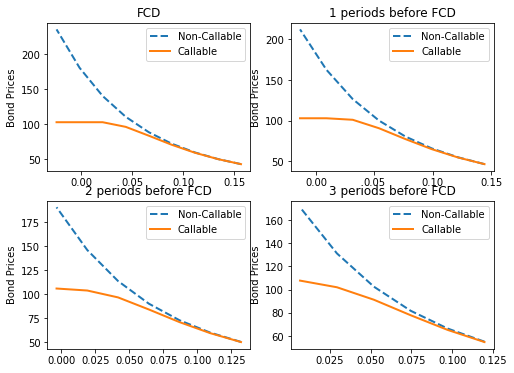

In [39]:
plt.figure(6,figsize=(8,6))
for j in range(1,5):
    plt.subplot(2,2,j)
    plt.plot(ImTree[0:iFCT-(j-1),iFCT-(j-1)],PPTree_NC[0:iFCT-(j-1),iFCT-(j-1)],'--',ImTree[0:iFCT-(j-1),iFCT-(j-1)],PPTree_C[0:iFCT-(j-1),iFCT-(j-1)],linewidth=2)
    #plt.xlabel('Interest Rate')
    plt.ylabel('Bond Prices')
    plt.legend(('Non-Callable','Callable'),loc='best')
    if j==1:
        titlestr = 'FCD'
    else:
        titlestr = str(j-1) + ' periods before FCD'
    plt.title(titlestr)

% Duration and Convexity

Duration - Non-Callable

In [40]:
DNC =  (PPTree_NC[1, 1]-PPTree_NC[0, 1])/ (PPTree_NC[0, 0]*(ImTree[0, 1]- ImTree[1, 1]))
DNC

11.85976567413916

Duration - Callable

In [41]:
DCallable = (PPTree_C[1, 1]-PPTree_C[0, 1])/ (PPTree_C[0, 0]*(ImTree[0, 1]- ImTree[1, 1]))
DCallable

6.921395403945519

Convexity - Non-Callable

In [42]:
Delta_NC_1u = (PPTree_NC[0,2]-PPTree_NC[1,2])/(ImTree[0,2]-ImTree[1,2])
Delta_NC_1d = (PPTree_NC[1,2]-PPTree_NC[2,2])/(ImTree[1,2]-ImTree[2,2])
C_NC = (Delta_NC_1u - Delta_NC_1d) / (PPTree_NC[0,0] * (ImTree[0,2] - ImTree[2,2]))
C_NC 

89.7968048389879

Convexity - Callable

In [43]:
Delta_Call_1u = (PPTree_C[0,2]-PPTree_C[1,2])/(ImTree[0,2]-ImTree[1,2])
Delta_Call_1d = (PPTree_C[1,2]-PPTree_C[2,2])/(ImTree[1,2]-ImTree[2,2])
C_Callable    = (Delta_Call_1u - Delta_Call_1d)/(PPTree_C[0,0] * (ImTree[0,2] - ImTree[2,2]))
C_Callable 

-9.454981573499332